# Infering the Parameters

We have our data and our simulation (see data_explore and model_simulation), now we need to estimate the parameters. In this notebook, we will assume that all parameters are the same between individuals and that variation between individuals is simply due to some error on each observation. This method of parameter estimation is Naive Pooled Inference.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from scipy import optimize, integrate
import pints
import pints.plot
import pandas
import plotly.express as px
import plotly.graph_objects as go

In [2]:
!pip install ipynb

## Pharmacokenetics - Linear Model

Let's begin with the Linear Pharmacokenetic model. We will first see whether we can fit the model to simulated data before trying to fit to the real data.

### Simulated Data

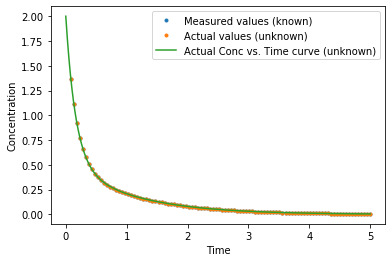

In [3]:
from ipynb.fs.full.model_simulation import PK_iv_result # import the required model

# Options
# (only num_comp really affects the model in the simulated case)
drug = 'Simulated Drug'
dose = 2
num_comp = 2

# Actual Parameters
# (This is only to produce the simulated data. These are 'unknown' when doing the inference)
Vol_C = 1
Cl = 2.5
k_perif = 2.3

# Create the Data
time_span = 5
num_obs = 100

data_times = np.concatenate((np.array([0]), np.linspace(0.083, time_span, num_obs)))
# data_times = [0, 0.083, 0.333,  2.5, 4.666, 4.833, 5] 
# Uncomment the above line if you want the simulated data to mimic the real data

noise = np.random.normal(0, 0, len(data_times))
values_no_noise = PK_iv_result(dose, num_comp, [Vol_C, Cl, k_perif], data_times)[:,0]
values_noisey = np.exp(np.log(values_no_noise) + noise)
df = pandas.DataFrame({'TIME' : data_times[1:], 'OBS' : values_noisey[1:]})

more_times = np.linspace(0,time_span,1000)
more_values = PK_iv_result(dose, num_comp, [Vol_C, Cl, k_perif], more_times)[:,0]

# Visualise the data
plt.plot(df['TIME'], df['OBS'], '.', label='Measured values (known)')
plt.plot(data_times[1:], values_no_noise[1:], '.', label='Actual values (unknown)')
plt.plot(more_times, more_values, label='Actual Conc vs. Time curve (unknown)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

In [4]:
df.to_csv(r'sythesised_data_proportional_data2.csv', index = False)
df['OBS'] = df['OBS'].abs()
df['log_value'] = np.log(df['OBS'])
print(df)

        TIME       OBS  log_value
0   0.083000  1.369119   0.314168
1   0.132667  1.113583   0.107583
2   0.182333  0.920689  -0.082633
3   0.232000  0.774125  -0.256022
4   0.281667  0.661872  -0.412683
..       ...       ...        ...
95  4.801333  0.005944  -5.125302
96  4.851000  0.005675  -5.171604
97  4.900667  0.005419  -5.217906
98  4.950333  0.005173  -5.264209
99  5.000000  0.004939  -5.310512

[100 rows x 3 columns]


In [5]:
# Create the model in PINTS 

class PintsLinCompIV(pints.ForwardModel):
    def n_parameters(self):
        return num_comp + 1
    def simulate(self, parameter, times):
        if times[0] == 0:
            return PK_iv_result(dose, num_comp, parameter, times)[:,0]
        elif times[0] > 0:  
            # If the times do not start at 0 then odeint will begin simulation at the first timepoint.
            # However our model assumes dosing happens at t=0 so we will need to add 0 to the times array and
            # then ignore the result at t=0.
            times = np.concatenate((np.array([0]), times))
            curve = PK_iv_result(dose, num_comp, parameter, times)[1:,0]
            # print(curve[curve<=0])
            return np.log(curve)

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     7      5141.604   0:00.1
1     14     209.6216   0:00.1
2     21     209.6216   0:00.2


/home/rumneyr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in log



3     28     209.6216   0:00.3
20    147    2.398565   0:01.4
40    287    2.398565   0:02.3
60    427    2.398565   0:03.2
80    567    2.362764   0:04.4
100   707    1.971139   0:05.8
120   847    1.971139   0:07.1
140   987    1.971139   0:08.4
160   1127   1.971139   0:09.7
180   1267   1.971139   0:11.1
200   1407   1.971139   0:12.3
220   1547   1.971139   0:13.6
240   1687   1.971139   0:14.9
260   1827   1.971139   0:16.3
280   1967   1.971139   0:17.6
296   2072   1.971139   0:18.5
Halting: No significant change for 200 iterations.
Pints calculation result: 	[1.4466379  2.0505936  9.93555674]
Pints error: 	1.9711390359723744


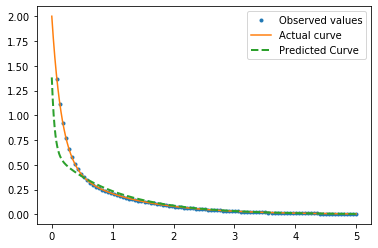

In [8]:
# Optimise the model with respect to the data
problem = pints.SingleOutputProblem(PintsLinCompIV(), df['TIME'].to_numpy(), np.log(df['OBS'].to_numpy()))
error_measure = pints.SumOfSquaresError(problem)
lower_bound = [0, 0, 0]
upper_bound = [50, 500, 500]
optimisation = pints.OptimisationController(error_measure, [1.2, 2, 2], method=pints.XNES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
# optimisation.set_log_to_screen(False)
parameters, error = optimisation.run()

# Show results
print('Pints calculation result: \t'+str(parameters))
print('Pints error: \t'+str(error))
plt.figure()
plt.plot(df['TIME'],  df['OBS'], '.', label='Observed values')
plt.plot(more_times, more_values, label='Actual curve')
plt.plot(more_times, PK_iv_result(dose, num_comp, parameters, more_times)[:,0], '--', lw=2, label='Predicted Curve')
plt.legend()

In [9]:
# Lets Visualise using Plotly

y_label = drug + " Concentration"
x_label = "Time"

fig = px.scatter(
    df,
    title=drug + " Concentration Mean",
    x="TIME",
    y="OBS",
    width=800, 
    height=500,
)

fig.update_xaxes(title_text=x_label)
fig.update_yaxes(title_text=y_label)
fig.update_traces(mode='markers+lines')
fig['data'][0]['showlegend']=True
fig['data'][0]['name']='Observed Values'
fig.add_trace(go.Scatter(x=more_times, y=PintsLinCompIV().simulate(parameters, more_times),
                    mode='lines',
                    name='Prediction'))
fig.add_trace(go.Scatter(x=more_times, y=more_values,
                    mode='lines',
                    name='Actual'))

fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="Linear y-scale",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="Log y-scale",
                    method="relayout"
                )
            ]),
            pad={"r": 0, "t": -10},
            showactive=True,
            x=1.0,
            xanchor="right",
            y=1.15,
            yanchor="top"
        ),
    ]
)
fig.show()

This is a useful way of estimating the correct parameters and visualising how good the model and estimated parameters fit the data. However, it would also be useful to know how sure we are on these parameter values. To do this we use Bayesian inference and MCMC to sample the parameter space and give a distribution of probable parameter values.

In [63]:
log_likelihood = pints.GaussianLogLikelihood(problem)
log_prior = pints.UniformLogPrior(lower_bound+[0], upper_bound+[1000])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

startpoints = [[1, 2, 3, 100],[0.5, 1, 2, 1],[2, 3, 1, 10]]
mcmc = pints.MCMCController(log_posterior, 3, startpoints, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(3000)
mcmc.set_log_to_screen(False)
samples = mcmc.run()

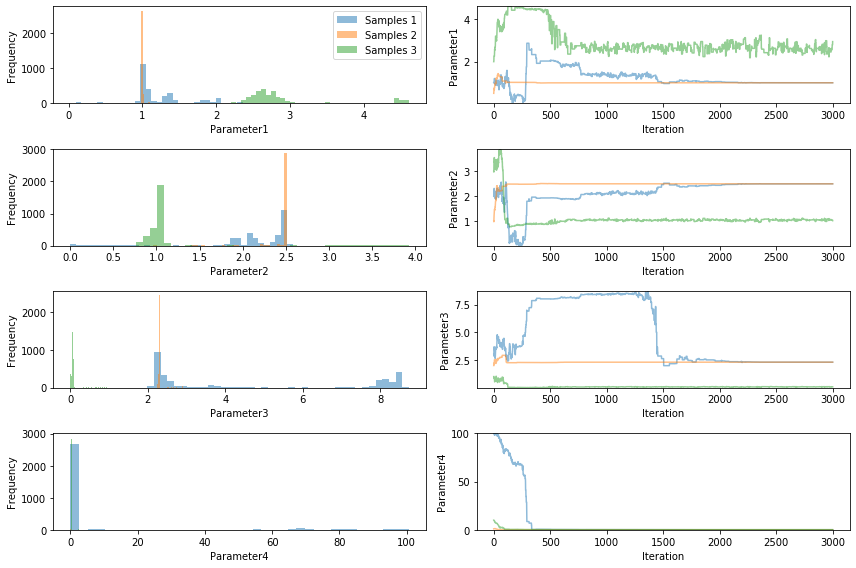

In [64]:
pints.plot.trace(samples)
plt.show()

### Real Data

Now we shall do the same as above but with Real data rather than simulated data. We do not know what the real parameters of the system are and so cannot truly know how accurately we are acquiring the correct results.

In [12]:
# Quick look at what the data contains
df = pandas.read_csv("0470-2008_2018-05-09.csv")
group = df.groupby('DRUG')
df_view = group.apply(lambda x: x['DOSE'].unique())
df_view = df_view.apply(pandas.Series)
df_view = df_view.replace(np.nan, '', regex=True)
df_view.columns = ['Dose 1', "Dose 2", "Dose 3"]
print(df_view)

             Dose 1 Dose 2 Dose 3
DRUG                             
Controls        0.0              
Docetaxel      15.0      5     10
Irinotecan     34.0     68       
Topotecan       7.5     15       
Vinflunine     10.0     20       
Vinorelbine     5.0     10     20


In [13]:
# Options: change to one of the above drugs and corresponding dose
drug = 'Docetaxel'
dose = 10
num_comp = 2

# Refine the Data
df = df.sort_values(['DOSE', 'TIME'], ascending=True)
df_drug = df.loc[(df['DOSE'] == dose)&(df['YNAME'] == drug)]

# Find average values
df_OBS = df_drug.drop(df_drug[df_drug['OBS'] == '.'].index)[['TIME', 'DOSE', 'OBS']]
df_OBS = df_OBS.astype({'OBS': 'float64'})
df_stats = df_OBS.groupby(["TIME", "DOSE"], as_index=False).filter(lambda x: len(x) > 1).groupby(["TIME", "DOSE"], as_index=False).agg({'OBS':['mean','std']})
df_stats.columns = ['TIME', "DOSE", 'mean', 'std']

# Get actual dose amount
dose_amount = df_drug.drop(df_drug[df_drug['AMT'] == '.'].index).astype({'AMT': 'float64'}).mean()['AMT']
print("Average dose amount = " + str(dose_amount))

Average dose amount = 1.9767777777777782


In [14]:
# Create the model in PINTS (This is the same model as above but with the new dose and num_comp)
class PintsLinCompIV(pints.ForwardModel):
    def n_parameters(self):
        return num_comp + 1
    def simulate(self, parameter, times):
        if times[0] == 0:
            return PK_iv_result(dose, num_comp, parameter, times)[:,0]
        elif times[0] > 0:  
            # If the times do not start at 0 then odeint will begin simulation at the first timepoint.
            # However our model assumes dosing happens at t=0 so we will need to add 0 to the times array and
            # then ignore the result at t=0.
            times = np.concatenate((np.array([0]), times))
            return PK_iv_result(dose, num_comp, parameter, times)[1:,0]

/home/rumneyr/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



Pints calculation result: 	[  1.81272112  13.22682187 499.05029512]
Pints error: 	3193.641792507447


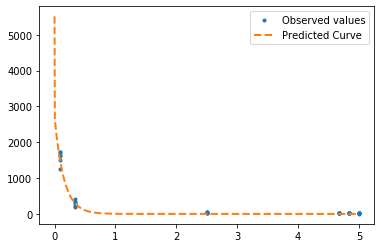

In [15]:
# Optimise the model with respect to the data
problem = pints.SingleOutputProblem(PintsLinCompIV(), df_stats['TIME'], df_stats['mean'])
error_measure = pints.SumOfSquaresError(problem)
lower_bound = [0, 0, 0]
upper_bound = [50, 500, 500]

optimisation = pints.OptimisationController(error_measure, [1, 1, 1], method=pints.XNES, boundaries=pints.RectangularBoundaries(lower_bound, upper_bound))
optimisation.set_log_to_screen(False)
parameters, error = optimisation.run()

# Quick visualisation

time_span = df_stats["TIME"].max()
times = np.linspace(0,time_span,1000)

print('Pints calculation result: \t'+str(parameters))
print('Pints error: \t'+str(error))
plt.figure()
plt.plot(df_OBS['TIME'],  df_OBS['OBS'], '.', label='Observed values')
plt.plot(times, PintsLinCompIV().simulate(parameters, times), '--', lw=2, label='Predicted Curve')
plt.legend()
plt.show()

In [16]:
# Visualisation using Plotly
y_label = drug + " Concentration"
x_label = "Time"

fig = px.scatter(
    df_stats,
    title=drug + " Concentration Mean",
    x="TIME",
    y="mean",
    error_y = "std",
    # facet_col="DOSE",
    # color="DOSE",
    width=800, 
    height=500,
)

fig.update_xaxes(title_text=x_label)
fig.update_yaxes(title_text=y_label)
fig.update_traces(mode='markers+lines')
fig['data'][0]['showlegend']=True
fig['data'][0]['name']='Observed Values'
fig.add_trace(go.Scatter(x=times, y=PintsLinCompIV().simulate(parameters, times),
                    mode='lines',
                    name='Prediction'))

fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="Linear y-scale",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="Log y-scale",
                    method="relayout"
                )
            ]),
            pad={"r": 0, "t": -10},
            showactive=True,
            x=1.0,
            xanchor="right",
            y=1.15,
            yanchor="top"
        ),
    ]
)
fig.show()

In [17]:
# A look at the distribution of the parameters
log_likelihood = pints.GaussianLogLikelihood(problem)
log_prior = pints.UniformLogPrior(lower_bound+[0], upper_bound+[1000])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

startpoints = [[1, 2, 3, 100],[0.5, 1, 2, 1],[2, 3, 1, 10]]
mcmc = pints.MCMCController(log_posterior, 3, startpoints, method=pints.HaarioBardenetACMC)
mcmc.set_max_iterations(3000)
mcmc.set_log_to_screen(False)
samples = mcmc.run()

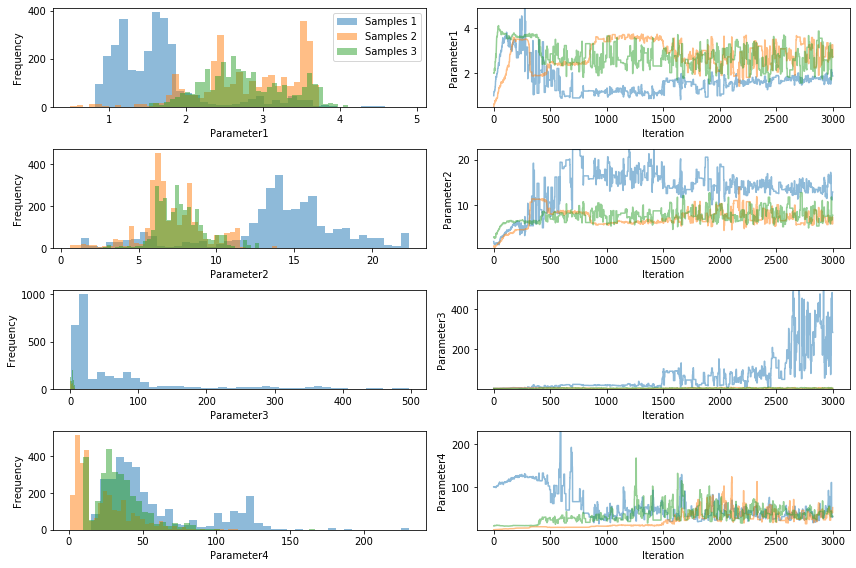

In [18]:
pints.plot.trace(samples)
plt.show()

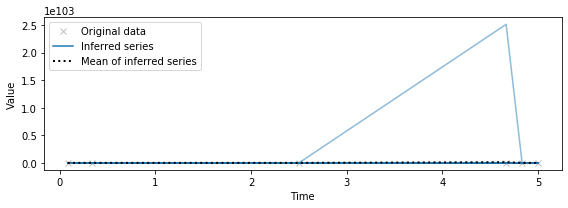

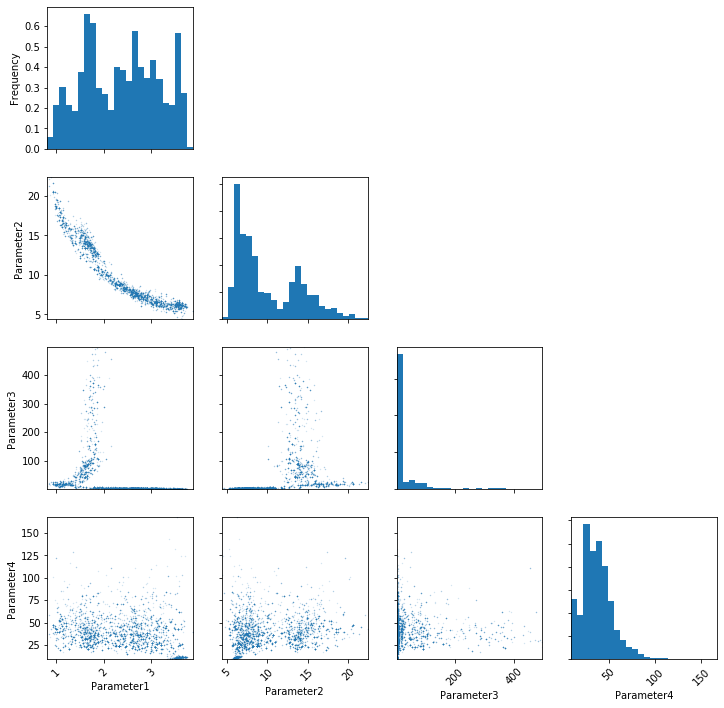

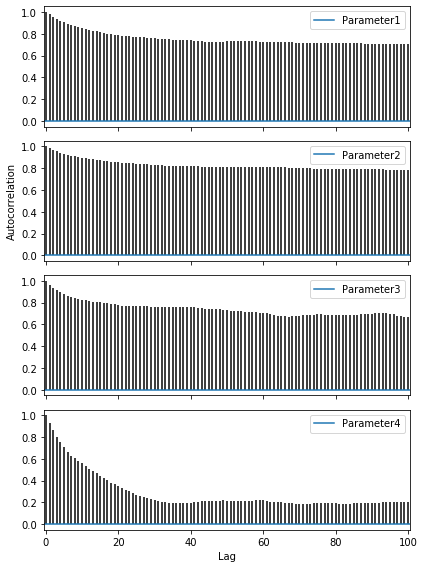

In [19]:
pints.plot.series(np.vstack(samples[:,1000:]), problem)
plt.show()
pints.plot.pairwise(np.vstack(samples[:,1000:]))
plt.show()
pints.plot.autocorrelation(np.vstack(samples[:,1000:]))
plt.show()